In [ ]:
import loompy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from cytograph.pipeline import load_config, PunchcardDeck
from cytograph.plotting import colorize
from cytograph.embedding import art_of_tsne
from urllib.request import urlretrieve
from sknetwork.hierarchy import cut_straight
import scipy.cluster.hierarchy as hc
import numpy_groupies as npg
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist
import seaborn
import matplotlib as mpl
import gget

# make font changeable in Illustrator
mpl.rcParams['pdf.fonttype'] = 42

# save figure with no pad
mpl.rcParams['savefig.pad_inches'] = 0
mpl.rcParams['savefig.bbox'] = 'tight'

# set axes width
mpl.rcParams['axes.linewidth'] = 0.2
mpl.rcParams['xtick.minor.pad'] = 0
mpl.rcParams['xtick.major.pad'] = 0
mpl.rcParams['ytick.minor.pad'] = 0
mpl.rcParams['ytick.major.pad'] = 0
mpl.rcParams['xtick.minor.width'] = 0.2
mpl.rcParams['xtick.major.width'] = 0.2
mpl.rcParams['ytick.minor.width'] = 0.2
mpl.rcParams['ytick.major.width'] = 0.2

# use colorblind seaborn style
plt.style.use('seaborn-colorblind')

In [7]:
folder = '/proj/human_adult/20220222/harmony/paris_top_bug/data/'

In [8]:
cbl = seaborn.color_palette('colorblind')
cbl

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

# GPCR ligand and receptor usage

In [ ]:
gpcr = pd.read_csv('GO-0007186_Downloaded20220627.txt', sep='\t', header=None)
gpcr.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,F2RL2,UniProtKB:O00254,Proteinase-activated receptor 3,NaN,GO:0004930,NaN,Reactome,NCBITaxon:9606,TAS,NaN,PANTHER:PTHR24232,protein,NaN,Reactome:R-HSA-114552,20201202
1,F2RL2,UniProtKB:O00254,Proteinase-activated receptor 3,NaN,GO:0004930,NaN,Reactome,NCBITaxon:9606,TAS,NaN,PANTHER:PTHR24232,protein,NaN,Reactome:R-HSA-114558,20201202
2,F2RL2,UniProtKB:O00254,Proteinase-activated receptor 3,NaN,GO:0015057,NaN,InterPro,NCBITaxon:9606,IEA,InterPro:IPR003912|InterPro:IPR003943,PANTHER:PTHR24232,protein,NaN,GO_REF:0000002,20220419
3,F2RL2,UniProtKB:O00254,Proteinase-activated receptor 3,NaN,GO:0070493,NaN,InterPro,NCBITaxon:9606,IEA,InterPro:IPR003912|InterPro:IPR003943,PANTHER:PTHR24232,protein,NaN,GO_REF:0000002,20220419
4,F2RL2,UniProtKB:O00254,Proteinase-activated receptor 3,NaN,GO:0004930,NaN,GO_Central,NCBITaxon:9606,IBA,PANTHER:PTN000660850|UniProtKB:P46093|ZFIN:ZDB...,PANTHER:PTHR24232,protein,NaN,PMID:21873635,20220415


In [ ]:
gpcr_genes = gpcr[0].unique()
gpcr_genes

array(['F2RL2', 'AGRP', 'MTNR1A', ..., 'DGKK', 'OR1E3', 'RAPGEF4'],
      dtype=object)

In [ ]:
gpcr_genes.shape

(1225,)

In [ ]:
gpcr_receptors = gpcr[0][gpcr[2].str.contains('receptor')].unique()
gpcr_other = gpcr[0][~gpcr[2].str.contains('receptor')].unique()

In [ ]:
np.sort(gpcr_receptors.astype('str'))

array(['A0A0G2JNH3', 'ACKR1', 'ACKR2', 'ACKR3', 'ACKR4', 'ADCYAP1R1',
       'ADGRA1', 'ADGRA2', 'ADGRA3', 'ADGRB1', 'ADGRB2', 'ADGRB3',
       'ADGRD1', 'ADGRD2', 'ADGRE1', 'ADGRE2', 'ADGRE3', 'ADGRE4P',
       'ADGRE5', 'ADGRF1', 'ADGRF2', 'ADGRF3', 'ADGRF4', 'ADGRF5',
       'ADGRG1', 'ADGRG2', 'ADGRG3', 'ADGRG4', 'ADGRG5', 'ADGRG6',
       'ADGRG7', 'ADGRL1', 'ADGRL2', 'ADGRL3', 'ADGRL4', 'ADGRV1',
       'ADORA1', 'ADORA2A', 'ADORA2B', 'ADORA3', 'ADRA1A', 'ADRA1B',
       'ADRA1D', 'ADRA2A', 'ADRA2B', 'ADRA2C', 'ADRB1', 'ADRB2', 'ADRB3',
       'AGTR1', 'AGTR2', 'AGTRAP', 'APELA', 'APLNR', 'AVPR1A', 'AVPR1B',
       'AVPR2', 'BDKRB1', 'BDKRB2', 'BRS3', 'C3AR1', 'C5AR1', 'C5AR2',
       'CALCR', 'CALCRL', 'CASR', 'CCKAR', 'CCKBR', 'CCR1', 'CCR10',
       'CCR2', 'CCR3', 'CCR4', 'CCR5', 'CCR6', 'CCR7', 'CCR8', 'CCR9',
       'CCRL2', 'CELSR1', 'CELSR2', 'CELSR3', 'CHRM1', 'CHRM2', 'CHRM3',
       'CHRM4', 'CHRM5', 'CMKLR1', 'CMKLR2', 'CNR1', 'CNR2', 'CRHR1',
       'CRHR2', 'CX3CR1'

In [ ]:
np.sort(gpcr_other.astype('str'))

array(['A0A3B3IT50', 'ABCA1', 'ACTN2', 'ADCY1', 'ADCY2', 'ADCY3', 'ADCY4',
       'ADCY5', 'ADCY6', 'ADCY7', 'ADCY8', 'ADCY9', 'ADCYAP1', 'ADM',
       'ADM2', 'ADM5', 'AGRN', 'AGRP', 'AGT', 'AHCYL1', 'AKAP12',
       'AKAP13', 'AKAP5', 'AKR1C2', 'AKR1C3', 'AKT1', 'ALOX15B', 'ANO1',
       'ANXA1', 'APLN', 'APLP2', 'APOA1', 'APOC3', 'APOE', 'AREG',
       'ARHGEF1', 'ARHGEF11', 'ARHGEF12', 'ARRB2', 'ATRNL1', 'AZU1',
       'BAIAP3', 'BCAR1', 'BCAR3', 'BHLHA15', 'C3', 'C5', 'CA2',
       'CACNA1D', 'CALCA', 'CALCB', 'CALM1', 'CALM2', 'CALM3', 'CAMK2A',
       'CARTPT', 'CAV1', 'CCL1', 'CCL11', 'CCL13', 'CCL14', 'CCL15',
       'CCL16', 'CCL17', 'CCL18', 'CCL19', 'CCL2', 'CCL20', 'CCL21',
       'CCL22', 'CCL23', 'CCL24', 'CCL25', 'CCL26', 'CCL3', 'CCL3L1',
       'CCL4', 'CCL4L1', 'CCL5', 'CCL7', 'CCL8', 'CD3E', 'CDC42',
       'CDK5R1', 'CGA', 'CGB1', 'CGB2', 'CGB3', 'CGB7', 'CHGA', 'CISH',
       'CNGB1', 'CNTN2', 'CORT', 'CPE', 'CRCP', 'CRKL', 'CX3CL1', 'CXCL1',
       'CXCL10', 'CXC

contain some ligands but not all, e.g. missing AVP. Will pull from neuropeptide hormone signaling GO:term. But still missing ligands for some GPCR receptors listed here, like APLN.

In [ ]:
npt = pd.read_csv('GO-0005184_Downloaded20220628.txt', sep='\t', header=None)
npt.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,AGRP,UniProtKB:O00253,Agouti-related protein,NaN,GO:0005184,NaN,UniProt,NCBITaxon:9606,IDA,NaN,PANTHER:PTHR16551,protein,NaN,PMID:15927146,20100705
1,AGRP,UniProtKB:O00253,Agouti-related protein,NaN,GO:0005184,NaN,GO_Central,NCBITaxon:9606,IBA,PANTHER:PTN000421821|ZFIN:ZDB-GENE-040817-1|MG...,PANTHER:PTHR16551,protein,NaN,PMID:21873635,20200326
2,CORT,UniProtKB:O00230,Cortistatin,NaN,GO:0005184,NaN,UniProt,NCBITaxon:9606,IDA,NaN,PANTHER:PTHR22980,protein,NaN,PMID:9125122,20120802
3,VGF,UniProtKB:O15240,Neurosecretory protein VGF,NaN,GO:0005184,NaN,Ensembl,NCBITaxon:9606,IEA,UniProtKB:Q0VGU4|ensembl:ENSMUSP00000140815,PANTHER:PTHR15159,protein,NaN,GO_REF:0000107,20220419
4,PRLH,UniProtKB:P81277,Prolactin-releasing peptide,NaN,GO:0005184,NaN,GO_Central,NCBITaxon:9606,IBA,PANTHER:PTN002704521|RGD:628634,PANTHER:PTHR17206,protein,NaN,PMID:21873635,20200408


In [ ]:
npt_genes = np.sort(npt[0].unique().astype('str'))
npt_genes

array(['ADCYAP1', 'AGRP', 'ASIP', 'AVP', 'CALCB', 'CARTPT', 'CCK', 'CORT',
       'CRH', 'GAL', 'GHRH', 'GRP', 'HCRT', 'NMB', 'NPFF', 'NPPA', 'NPY',
       'NTS', 'OXT', 'PENK', 'PNOC', 'PPY', 'PRLH', 'PYY', 'PYY3', 'QRFP',
       'SPX', 'UCN', 'VGF', 'VIP'], dtype='<U7')

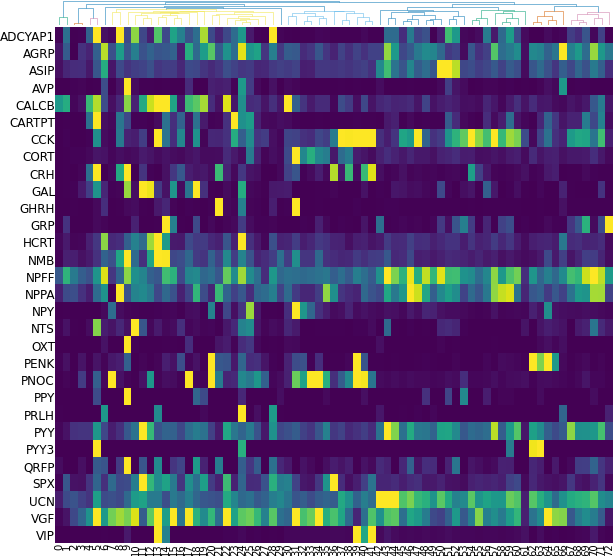

In [ ]:
with loompy.connect(f'{folder}/harmony_A.agg.loom', 'r') as ds:
    
    plt.figure(None, (10, 10))
    gs = plt.GridSpec(40, 1)
    
    plt.subplot(gs[:2])
    with plt.rc_context({'lines.linewidth': 0.5}):
        hc.dendrogram(ds.attrs.linkage)
    
    plt.axis('off')
    # heatmap
    ax = plt.subplot(gs[2:])
    # list of gene names
    genes = npt_genes
    # stack into an array
    gdata = np.vstack([ds[ds.ra.Gene == g, :][0] for g in genes])
    gdata = np.log2(gdata + 1)
    gdata = (gdata.T / np.percentile(gdata, 99, axis=1)).T
    # imshow shows the heatmap
    # use vmax if you want to cap the heatmap values
    plt.imshow(gdata, vmax=0.8, aspect='auto', cmap="viridis", interpolation='nearest')
    # some plot params
    plt.box(on=None)
    plt.yticks(range(len(genes)), genes, fontsize=12)
    plt.xticks(range(ds.shape[1]), rotation=90)
    ax.tick_params(length=0)

In [ ]:
def enrichment(nonzeros, cluster_size, means=None):

    n_clusters = nonzeros.shape[1]
    f_nnz = nonzeros / cluster_size
    
    # calculate enrichment scores
    enrichment = np.zeros_like(nonzeros)
    for j in range(n_clusters):
        # calculate cluster weights
        ix = np.arange(n_clusters) != j
        weights = cluster_size[ix] / cluster_size[ix].sum()
        # calculate f_nnz as weighted average
        f_nnz_other = np.average(f_nnz[:, ix], weights=weights, axis=1)
        if means is not None:
            # calculate means_other as weighted average
            means_other = np.average(means[:, ix], weights=weights, axis=1)
            # calculate enrichment
            enrichment[:, j] = (f_nnz[:, j] + 0.1) / (f_nnz_other + 0.1) * (means[:, j] + 0.01) / (means_other + 0.01)
        else:
            # calculate enrichment
            enrichment[:, j] = (f_nnz[:, j] + 0.1) / (f_nnz_other + 0.1)
        
    return enrichment

In [ ]:
with loompy.connect(f'{folder}/harmony_A.loom', 'r') as ds:
    
    cluster_groups = [np.unique(ds.ca.Clusters[ds.ca.Subset == x]) for x in np.unique(ds.ca.Subset)]
    
with loompy.connect(f'{folder}/harmony_A.agg.loom', 'r') as ds:
    
    grp = lambda x: np.where(np.isin(ds.ca.Clusters, x))[0]
    
    means = np.vstack(
        [ 
            np.average(ds[:, grp(x)], weights=ds.ca.NCells[grp(x)], axis=1) for x in cluster_groups
        ]
    ).T
    
    nonzeros = np.vstack(
        [ np.average(ds['nonzeros'][:, grp(x)], weights=ds.ca.NCells[grp(x)], axis=1) for x in cluster_groups
        ]
    ).T
    
    cluster_size = np.array(
        [ds.ca.NCells[grp(x)].sum() for x in cluster_groups]
    )

In [ ]:
means.shape, nonzeros.shape

((59480, 21), (59480, 21))

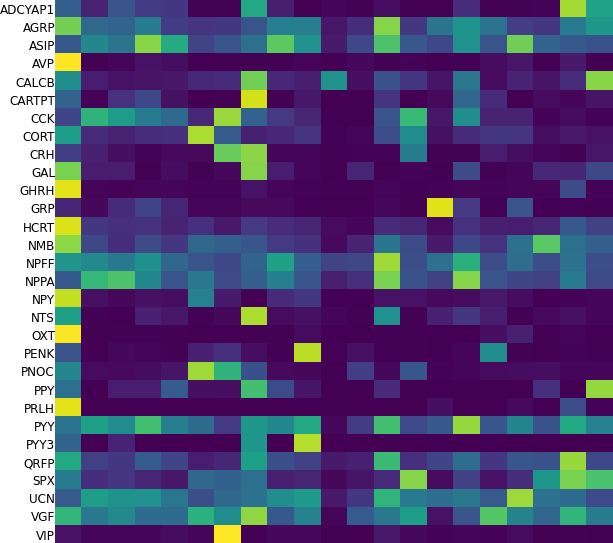

In [ ]:
with loompy.connect(f'{folder}/harmony_A.agg.loom', 'r') as ds:
    
    plt.figure(None, (10, 10))
    gs = plt.GridSpec(40, 1)

    plt.axis('off')
    # heatmap
    ax = plt.subplot(gs[:])
    # list of gene names
    genes = npt_genes
    # stack into an array
    gdata = np.vstack([means[ds.ra.Gene == g, :][0] for g in genes])
    gdata = np.log2(gdata + 1)
    gdata = (gdata.T / np.percentile(gdata, 99, axis=1)).T
    # imshow shows the heatmap
    # use vmax if you want to cap the heatmap values
    plt.imshow(gdata, aspect='auto', cmap="viridis", interpolation='nearest')
    # some plot params
    plt.box(on=None)
    plt.yticks(range(len(genes)), genes, fontsize=12)
    plt.xticks([])
    ax.tick_params(length=0)

In [ ]:
f_nnz = nonzeros / cluster_size

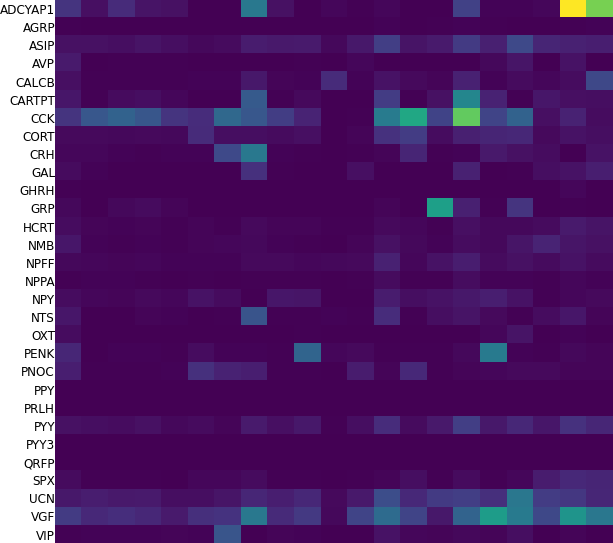

In [ ]:
with loompy.connect(f'{folder}/harmony_A.agg.loom', 'r') as ds:
    
    plt.figure(None, (10, 10))
    gs = plt.GridSpec(40, 1)
        
    plt.axis('off')
    # heatmap
    ax = plt.subplot(gs[:])
    # list of gene names
    genes = npt_genes
    # stack into an array
    gdata = np.vstack([f_nnz[ds.ra.Gene == g, :][0] for g in genes])
    # imshow shows the heatmap
    # use vmax if you want to cap the heatmap values
    plt.imshow(gdata, aspect='auto', cmap="viridis", interpolation='nearest')
    # some plot params
    plt.box(on=None)
    plt.yticks(range(len(genes)), genes, fontsize=12)
    plt.xticks([])
    ax.tick_params(length=0)

In [ ]:
hgnc_npt = pd.read_csv('hgnc_neuropeptides.csv')['Approved symbol'].unique()
hgnc_npt

array(['ADCYAP1', 'ADM', 'ADM2', 'AGRP', 'AGT', 'APLN', 'AVP', 'CALCA',
       'CALCB', 'CCK', 'CHGA', 'CRH', 'GAL', 'GALP', 'GAST', 'GHRH',
       'GHRL', 'GIP', 'GNRH1', 'GNRH2', 'GRP', 'HCRT', 'IAPP', 'IGF1',
       'IGF2', 'INS', 'KISS1', 'KNG1', 'LEP', 'MLN', 'NMS', 'NMU', 'NPB',
       'NPFF', 'NPPA', 'NPPB', 'NPPC', 'NPS', 'NPVF', 'NPW', 'NPY', 'NTS',
       'OXT', 'PDYN', 'PENK', 'PMCH', 'PNOC', 'POMC', 'PPY', 'PRL',
       'PRLH', 'PTHLH', 'PYY', 'RLN1', 'RLN2', 'RLN3', 'SCT', 'SST',
       'TRH', 'UCN', 'UCN2', 'UCN3', 'UTS2', 'VIP'], dtype=object)

NameError: name 'means' is not defined

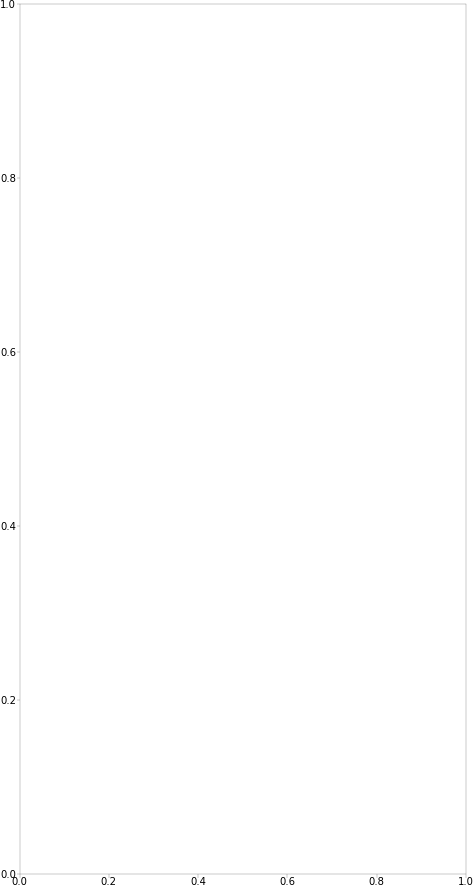

In [9]:
with loompy.connect(f'{folder}/harmony_A.agg.loom', 'r') as ds:
    
    plt.figure(None, (8, 16))
    gs = plt.GridSpec(40, 1)
        
    plt.axis('off')
    # heatmap
    ax = plt.subplot(gs[:])
    # list of gene names
    genes = hgnc_npt
    # stack into an array
    gdata = np.vstack([means[ds.ra.Gene == g, :][0] for g in genes])
    gdata = np.log2(gdata + 1)
    gdata = (gdata.T / np.max(gdata, axis=1)).T
    # use vmax if you want to cap the heatmap values
    plt.imshow(gdata, aspect='auto', cmap="viridis", interpolation='nearest')
    # some plot params
    plt.box(on=None)
    plt.yticks(range(len(genes)), genes, fontsize=12)
    plt.xticks([])
    ax.tick_params(length=0)

Major neurotransmitters (wikipedia):

- Amino acids: glutamate,[23] aspartate, D-serine, gamma-Aminobutyric acid (GABA),[nb 1] glycine
- Gasotransmitters: nitric oxide (NO), carbon monoxide (CO), hydrogen sulfide (H2S)
- Monoamines: dopamine (DA), norepinephrine (noradrenaline; NE, NA), epinephrine (adrenaline), histamine, serotonin (SER, 5-HT)
- Catecholamines: dopamine, norepinephrine (noradrenaline), epinephrine (adrenaline)
- Trace amines: phenethylamine, N-methylphenethylamine, tyramine, 3-iodothyronamine, octopamine, tryptamine, etc.
- Peptides: oxytocin, somatostatin, substance P, cocaine and amphetamine regulated transcript, opioid peptides[24]
- Purines: adenosine triphosphate (ATP), adenosine
- Others: acetylcholine (ACh), anandamide, etc.

In [33]:
ntm = [
    'SLC17A7', # Glut
    'SLC17A6', 
    'SLC17A8',
    'GAD1', # Gaba
    'GAD2',
    'SLC5A7', # cholinergic
    'CHAT',
    'TH', # dopamine
    'SLC6A3',
    'TPH2', # serotonin
    'FEV',
    'SLC6A2', # norepinephrine
    'DBH',
    'PNMT', # epinephrine
    'SLC6A5' # glycine
]

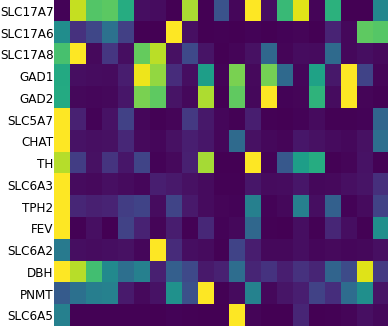

In [34]:
with loompy.connect(f'{folder}/harmony_A.agg.loom', 'r') as ds:
    
    plt.figure(None, (6, 6))
    gs = plt.GridSpec(40, 1)
        
    plt.axis('off')
    # heatmap
    ax = plt.subplot(gs[:])
    # list of gene names
    genes = ntm
    # stack into an array
    gdata = np.vstack([means[ds.ra.Gene == g, :][0] for g in genes])
    gdata = np.log2(gdata + 1)
    gdata = (gdata.T / np.max(gdata, axis=1)).T
    # use vmax if you want to cap the heatmap values
    plt.imshow(gdata, aspect='auto', cmap="viridis", interpolation='nearest')
    # some plot params
    plt.box(on=None)
    plt.yticks(range(len(genes)), genes, fontsize=12)
    plt.xticks([])
    ax.tick_params(length=0)

In [53]:
with loompy.connect(folder + f'harmony_A_A.loom', 'r') as ds:

    g1_bool = (ds[ds.ra.Gene == 'SLC17A6', :].flatten() > exp_thresh)
    test = np.array(
        [
        (g1_bool & (ds[ds.ra.Gene == g2, :].flatten() > exp_thresh)).sum() / g1_bool.sum()
        for g2 in ntm
        ]
    )

In [54]:
test

array([0.01968216, 1.        , 0.07289979, 0.14886647, 0.14870964,
       0.08939307, 0.02386429, 0.03249865, 0.00548905, 0.04636939,
       0.00521024, 0.0043651 , 0.00766724, 0.06626065, 0.01240699])

In [84]:
cd /proj/human_adult/20220222/harmony/paris_top_bug

/proj/human_adult/20220222/harmony/paris_top_bug


In [85]:
config = load_config()
deck = PunchcardDeck(config.paths.build)
leaves = deck.get_leaves()
len(leaves)

31

In [87]:
neuron_leaves = [subset.longname() for subset in leaves if subset.longname().startswith('harmony_A_')]
neuron_leaves[:3]

['harmony_A_A', 'harmony_A_B', 'harmony_A_D']

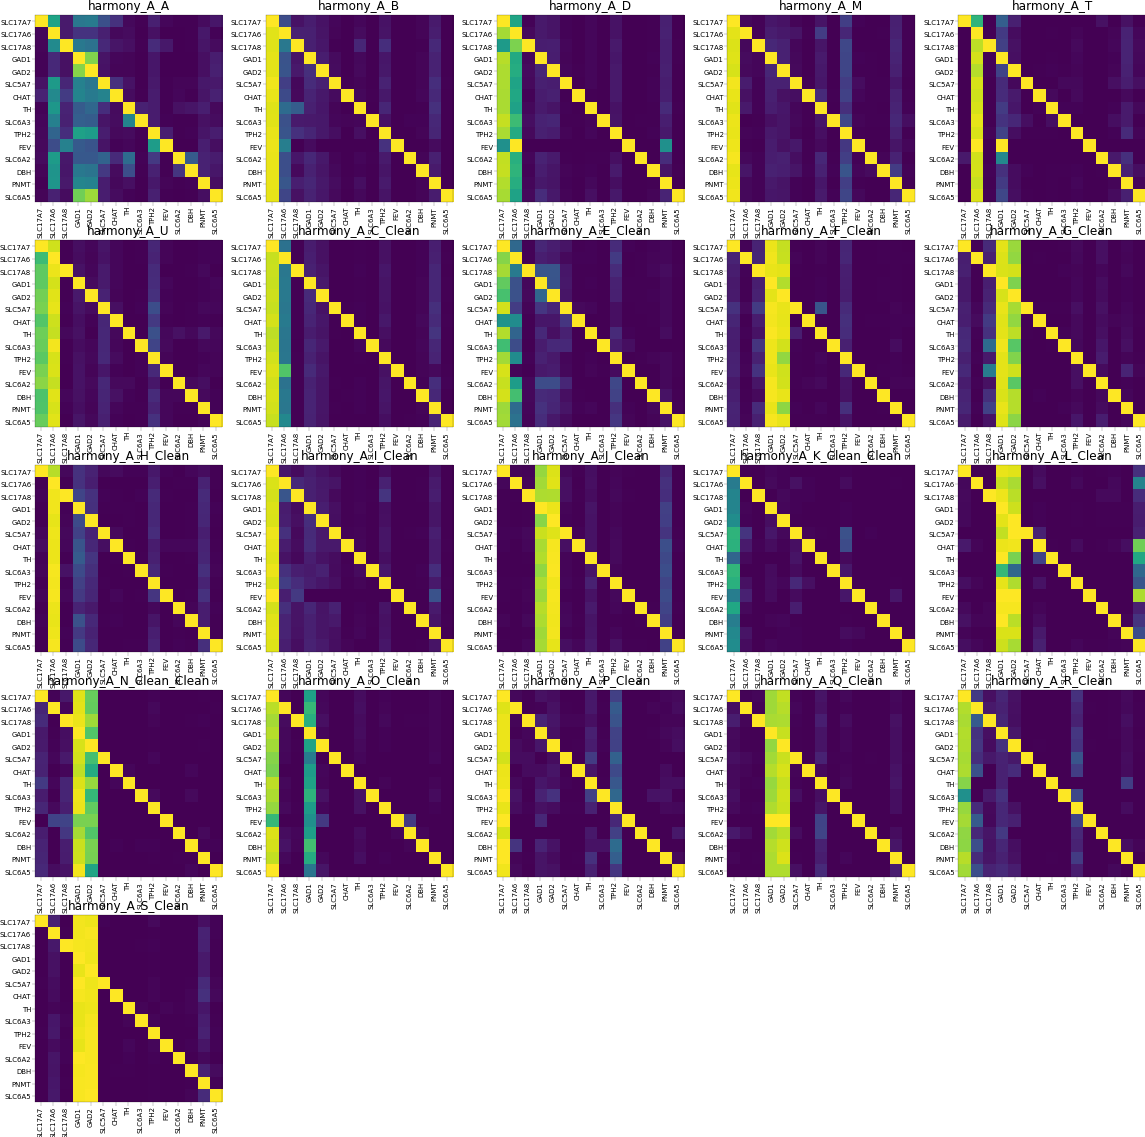

CPU times: user 10min 12s, sys: 15 s, total: 10min 27s
Wall time: 10min 35s


In [88]:
%%time

plt.figure(None, (20, 20))
gs = plt.GridSpec(5, 5)

exp_thresh = 0

for n, subset in enumerate(neuron_leaves):

    with loompy.connect(folder + f'{subset}.loom', 'r') as ds:
    
        coexp_mat = np.zeros((len(ntm), len(ntm)))
        for i, g1 in enumerate(ntm):
            g1_bool = (ds[ds.ra.Gene == g1, :] > exp_thresh)
            coexp_mat[i, :] = np.array(
                [
                (g1_bool & (ds[ds.ra.Gene == g2, :] > exp_thresh)).sum() / g1_bool.sum()
                for g2 in ntm
                ]
            )
        plt.subplot(gs[n])
        plt.imshow(coexp_mat)
        plt.xticks(range(len(ntm)), ntm, fontsize=7, rotation=90)
        plt.yticks(range(len(ntm)), ntm, fontsize=7)
        plt.title(subset)

plt.show()

<timed exec>:15: RuntimeWarning: invalid value encountered in long_scalars


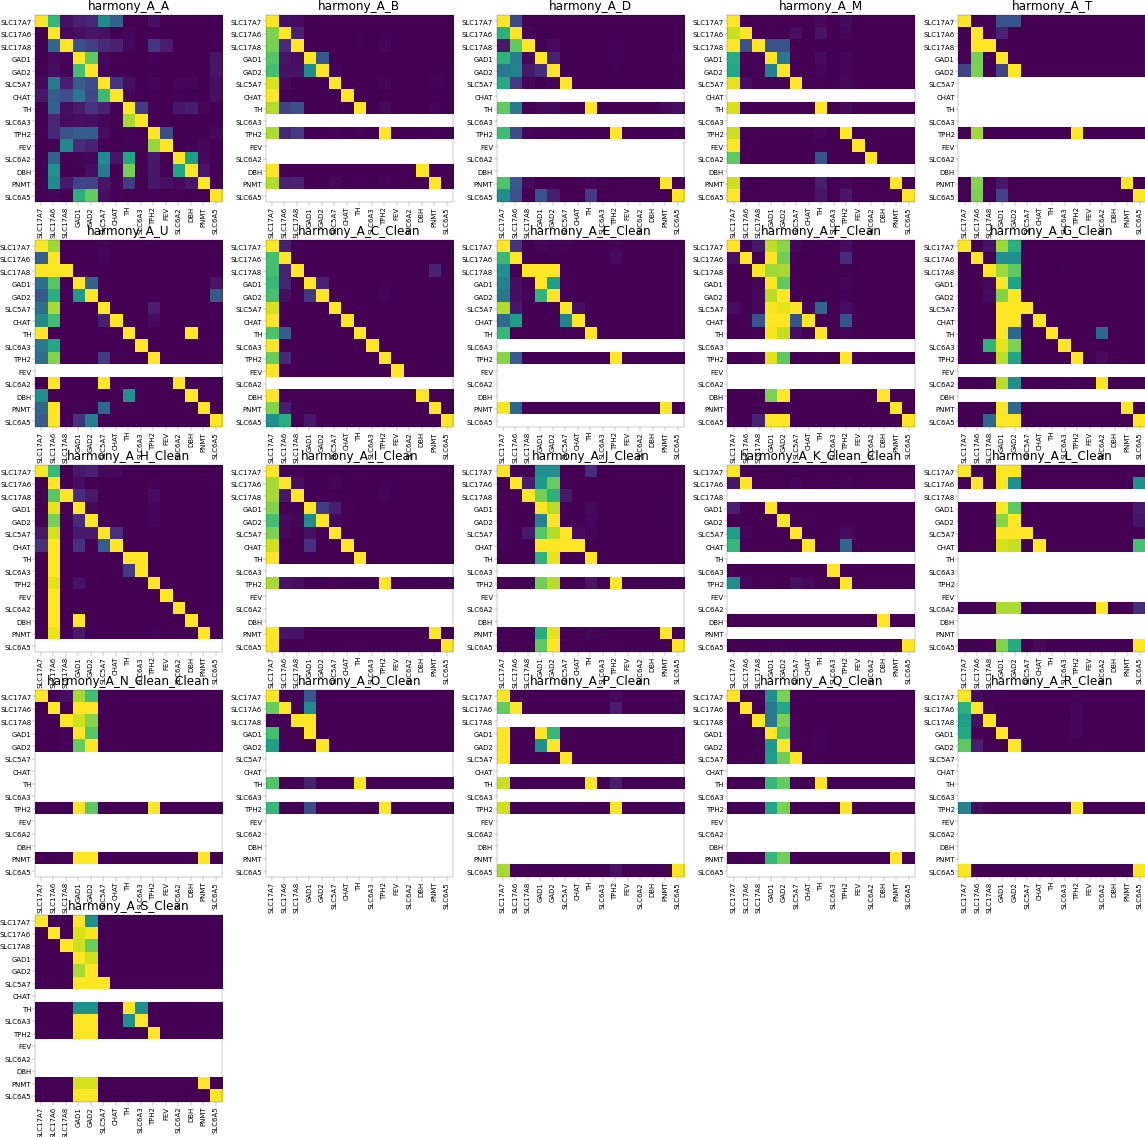

CPU times: user 10min 5s, sys: 15.5 s, total: 10min 20s
Wall time: 10min 42s


In [89]:
%%time

plt.figure(None, (20, 20))
gs = plt.GridSpec(5, 5)

exp_thresh = 2

for n, subset in enumerate(neuron_leaves):

    with loompy.connect(folder + f'{subset}.loom', 'r') as ds:
    
        coexp_mat = np.zeros((len(ntm), len(ntm)))
        for i, g1 in enumerate(ntm):
            g1_bool = (ds[ds.ra.Gene == g1, :] > exp_thresh)
            coexp_mat[i, :] = np.array(
                [
                (g1_bool & (ds[ds.ra.Gene == g2, :] > exp_thresh)).sum() / g1_bool.sum()
                for g2 in ntm
                ]
            )
        plt.subplot(gs[n])
        plt.imshow(coexp_mat)
        plt.xticks(range(len(ntm)), ntm, fontsize=7, rotation=90)
        plt.yticks(range(len(ntm)), ntm, fontsize=7)
        plt.title(subset)

plt.show()